In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pylab as pl
import sklearn.cross_validation, sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction import DictVectorizer, FeatureHasher
import scipy.stats

%matplotlib inline
pd.set_option('display.mpl_style', 'default')
pl.rcParams['figure.figsize'] = (20, 10)

train = pd.read_csv('train.csv', low_memory=False)
test = pd.read_csv('test.csv', low_memory=False)
types = np.unique(train.TripType.values)
types_dictionary = {t: i for i, t in  enumerate(types)}

In [2]:
def at(l):
    return l.iloc[0]
def mklist(l):
    return list(l)

train = train.groupby('VisitNumber').agg({'TripType': at, 'Weekday': at, 'ScanCount': mklist, 'DepartmentDescription': at,
                                          'FinelineNumber': mklist, 'Upc': mklist}).reset_index()
test = test.groupby('VisitNumber').agg({'Weekday': at, 'ScanCount': mklist, 'DepartmentDescription': at,
                                        'FinelineNumber': mklist, 'Upc': mklist}).reset_index()


In [3]:
def construct_features(data):
    data['NumberOfItems'] = data.Upc.map(lambda x: len(x))
    data['SumOfReturned'] = data.ScanCount.map(lambda x: sum([a for a in x if a < 0]))
    return data

In [4]:
train = construct_features(train)
test = construct_features(test)

/home/oem/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


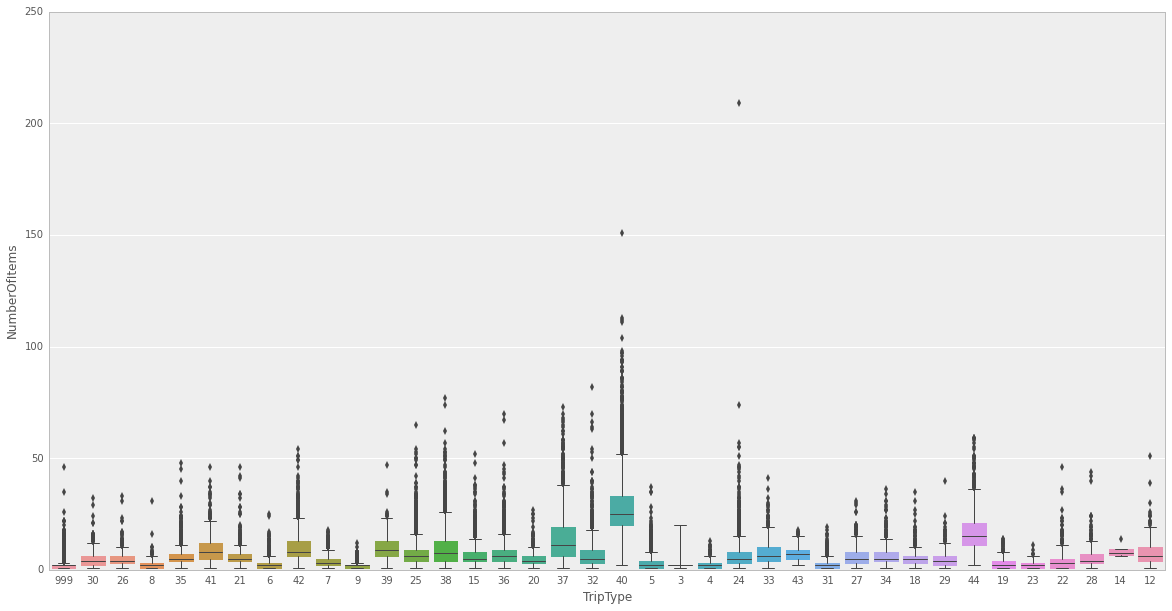

In [5]:
sns.boxplot('TripType', 'NumberOfItems', data=train)

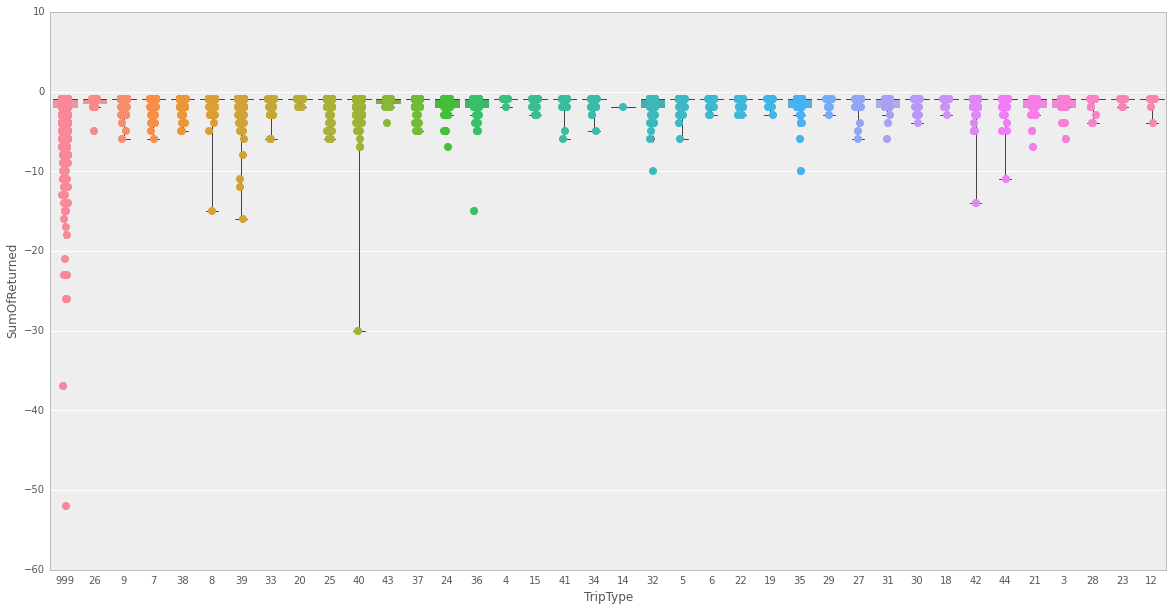

In [6]:
sns.boxplot('TripType', 'SumOfReturned', data=train[train.SumOfReturned != 0])
sns.stripplot('TripType', 'SumOfReturned', jitter=True, data=train[train.SumOfReturned != 0])



In [7]:
def get_prior_probabilities(data):
    prior_probabilities = np.zeros(len(types))
    prior_probabilities += np.array([len(data[data.TripType == trip_type]) for trip_type in types])
    prior_probabilities /= prior_probabilities.sum()
    return prior_probabilities

In [23]:
def construct_dummy_features(data, dummy_columns):
    data = pd.get_dummies(data, sparse=True, dummy_na=False, columns=dummy_columns)
    return data

In [24]:
print('Memory usage of dataframe train is %3.2f Mb' % (train.memory_usage(index=True).sum()/(1024*1024)))
print('Memory usage of dataframe test is %3.2f Mb' % (test.memory_usage(index=True).sum()/(1024*1024)))

Memory usage of dataframe train is 7.30 Mb
Memory usage of dataframe test is 6.57 Mb


In [25]:
data = train.append(test)
data = data[[col for col in data.columns if col not in ['Upc', 'ScanCount', 'FinelineNumber']]]
data = construct_dummy_features(data, ['Weekday', 'DepartmentDescription'])
train_dummies = data.iloc[:len(train)]
test_dummies = data.iloc[len(train):]
del data, test_dummies['TripType']
print(len(test_dummies.columns), 'features constructed')

78 features constructed


In [26]:
print('Memory usage of dataframe train_dummies is %3.2f Mb' % (train_dummies.memory_usage(index=True).sum()/(1024*1024)))
print('Memory usage of dataframe test_dummies is %3.2f Mb' % (test_dummies.memory_usage(index=True).sum()/(1024*1024)))

Memory usage of dataframe train_dummies is 5.11 Mb
Memory usage of dataframe test_dummies is 4.38 Mb


In [27]:
def fit_predict(train_array, train_labels, test_array, prior_probabilities=None, algorithm='rf'):
    if algorithm == 'rf':
        clf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=1, max_features=0.2, n_jobs=-1)
        
    clf.fit(train_array, train_labels)
    prediction_matrix = clf.predict_proba(test_array)
    if not prior_probabilities is None:
        coeff = 0.1
        prediction_matrix = (prediction_matrix + [prior_probabilities*coeff]*len(prediction_matrix))/(1. + coeff)
    return prediction_matrix

##MAIN

In [30]:
algorithms = ['rf']
algorithm = 'rf'

validation = False

if validation:
    y = train_dummies.TripType.values
    
    for train_indices, test_indices in sklearn.cross_validation.StratifiedShuffleSplit(y, n_iter=1, test_size=0.1):
        data_train = train_dummies.iloc[train_indices]
        data_test = train_dummies.iloc[test_indices]
        
#         prior_probabilities = get_prior_probabilities(data_train)
        
        prediction_matrix = fit_predict(data_train[[col for col in data_train.columns 
                                                    if col not in ['TripType', 'VisitNumber']]].values, 
                                        data_train.TripType.values, 
                                        data_test[[col for col in data_test.columns 
                                                   if col not in ['TripType', 'VisitNumber']]].values, 
                                        algorithm=algorithm)
        
        prediction_matrix = np.delete(prediction_matrix, 7, axis=1)
        
        y_true = data_test.TripType.values
        
        log_loss = sklearn.metrics.log_loss(y_true, prediction_matrix) 
        
        print('log_loss =', log_loss)
     
    del y, y_true, data_train, data_test, prediction_matrix, log_loss
    
elif not validation:
#     prior_probabilities = get_prior_probabilities(train)
    prediction_matrix = fit_predict(train_dummies[[col for col in train_dummies.columns 
                                            if col not in ['TripType', 'VisitNumber']]].values, 
                                    train_dummies.TripType.values, 
                                    test_dummies[[col for col in test_dummies.columns if col not in ['VisitNumber']]].values, 
                                    algorithm=algorithm)
    
    prediction_df = pd.DataFrame(prediction_matrix, columns=['TripType_' + str(i) for i in types])
    prediction_df['VisitNumber'] = test_dummies.VisitNumber
    
    prediction_df = prediction_df[['VisitNumber'] + [x for x in prediction_df.columns if x != 'VisitNumber']]
    del prediction_matrix
    filename = 'prediction.csv'
    prediction_df.to_csv(filename, index=False)
    print(filename, 'was created')
    del prediction_df
    

prediction.csv was created
